<a href="https://colab.research.google.com/github/naufalkr/XAI-erp-transaction-anomaly/blob/main/ERP_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset and Dependencies

In [1]:
!pip install jupyterthemes

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style()
import seaborn as sns
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/naufalkr/XAI-erp-transaction-anomaly/main/financial_anomaly_data.csv')
df.shape

(217441, 7)

In [3]:
df.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [4]:
df.tail()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
217436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217440,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.count()

,0
Timestamp,216960
TransactionID,216960
AccountID,216960
Amount,216960
Merchant,216960
TransactionType,216960
Location,216960


In [6]:
df.dtypes

,0
Timestamp,object
TransactionID,object
AccountID,object
Amount,float64
Merchant,object
TransactionType,object
Location,object


In [7]:
df.describe()

,Amount
count,216960.000000
mean,50090.025108
std,29097.905016
min,10.510000
25%,25061.242500
50%,50183.980000
75%,75080.460000
max,978942.260000


# Handling Missing Value


In [8]:
df.isna().sum()

,0
Timestamp,481
TransactionID,481
AccountID,481
Amount,481
Merchant,481
TransactionType,481
Location,481


In [9]:
value_counts = {column: df[column].value_counts() for column in df.columns}
value_counts

{'Timestamp': Timestamp
 01-01-2023 08:00    1
 11-04-2023 18:57    1
 11-04-2023 18:33    1
 11-04-2023 18:34    1
 11-04-2023 18:35    1
                    ..
 20-02-2023 13:23    1
 20-02-2023 13:24    1
 20-02-2023 13:25    1
 20-02-2023 13:26    1
 31-05-2023 23:59    1
 Name: count, Length: 216960, dtype: int64,
 'TransactionID': TransactionID
 TXN838     139
 TXN1768    139
 TXN1658    139
 TXN1389    138
 TXN340     137
           ... 
 TXN60       79
 TXN891      78
 TXN605      78
 TXN201      73
 TXN799      70
 Name: count, Length: 1999, dtype: int64,
 'AccountID': AccountID
 ACC15    14701
 ACC5     14630
 ACC7     14581
 ACC2     14553
 ACC9     14527
 ACC14    14458
 ACC4     14456
 ACC11    14446
 ACC12    14421
 ACC13    14421
 ACC8     14402
 ACC1     14365
 ACC10    14362
 ACC6     14352
 ACC3     14285
 Name: count, dtype: int64,
 'Amount': Amount
 18010.00    3
 34588.69    3
 74109.74    3
 86099.64    3
 7309.50     3
            ..
 56652.57    1
 36336.36    1

In [10]:
# Convert the 'Timestamp' column to datetime format if it isn't already
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

# Extract the date (year-month-day) without the time
df['Date'] = df['Timestamp'].dt.date

# Calculate value counts for each unique date
date_counts = df['Date'].value_counts().sort_index()

date_counts

,count
Date,
2023-01-01,960
2023-01-02,1440
2023-01-03,1440
2023-01-04,1440
2023-01-05,1440
...,...
2023-05-27,1440
2023-05-28,1440
2023-05-29,1440


In [11]:
df.isna().sum()

,0
Timestamp,481
TransactionID,481
AccountID,481
Amount,481
Merchant,481
TransactionType,481
Location,481
Date,481


In [12]:
transaction_counts = df['TransactionType'].value_counts()

# Display the counts
print(transaction_counts)

TransactionType
Transfer      72793
Purchase      72235
Withdrawal    71932
Name: count, dtype: int64


In [13]:
df = df.dropna()
df.isna().sum()

,0
Timestamp,0
TransactionID,0
AccountID,0
Amount,0
Merchant,0
TransactionType,0
Location,0
Date,0


In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')
df

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Date
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,2023-01-01
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,2023-01-01
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,2023-01-01
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,2023-01-01
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,2023-01-01
...,...,...,...,...,...,...,...,...
216955,2023-05-31 23:55:00,TXN1286,ACC6,62536.88,MerchantA,Withdrawal,San Francisco,2023-05-31
216956,2023-05-31 23:56:00,TXN1015,ACC5,68629.69,MerchantG,Transfer,London,2023-05-31
216957,2023-05-31 23:57:00,TXN1979,ACC15,8203.57,MerchantF,Purchase,London,2023-05-31
216958,2023-05-31 23:58:00,TXN1845,ACC14,77800.36,MerchantF,Purchase,New York,2023-05-31


In [15]:
df.count()

,0
Timestamp,216960
TransactionID,216960
AccountID,216960
Amount,216960
Merchant,216960
TransactionType,216960
Location,216960
Date,216960


In [16]:
df.iloc[9]

,9
Timestamp,2023-01-01 08:09:00
TransactionID,TXN1479
AccountID,ACC12
Amount,49522.74
Merchant,MerchantC
TransactionType,Withdrawal
Location,New York
Date,2023-01-01


# Exploratory Data Analysis (EDA)

<Axes: xlabel='Timestamp'>

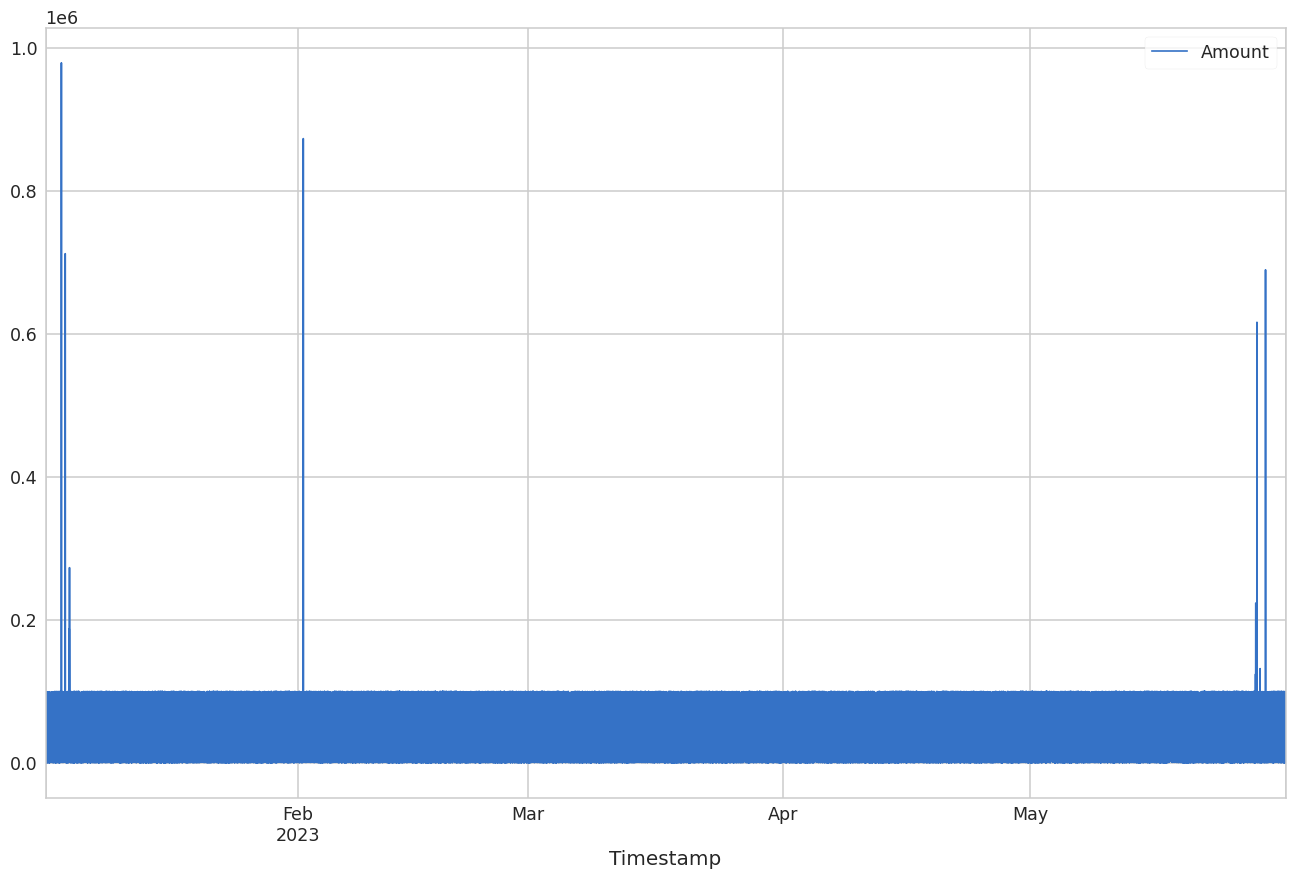

In [17]:
# Transaction based on timestamp
df.set_index('Timestamp').plot(figsize=(16, 10))

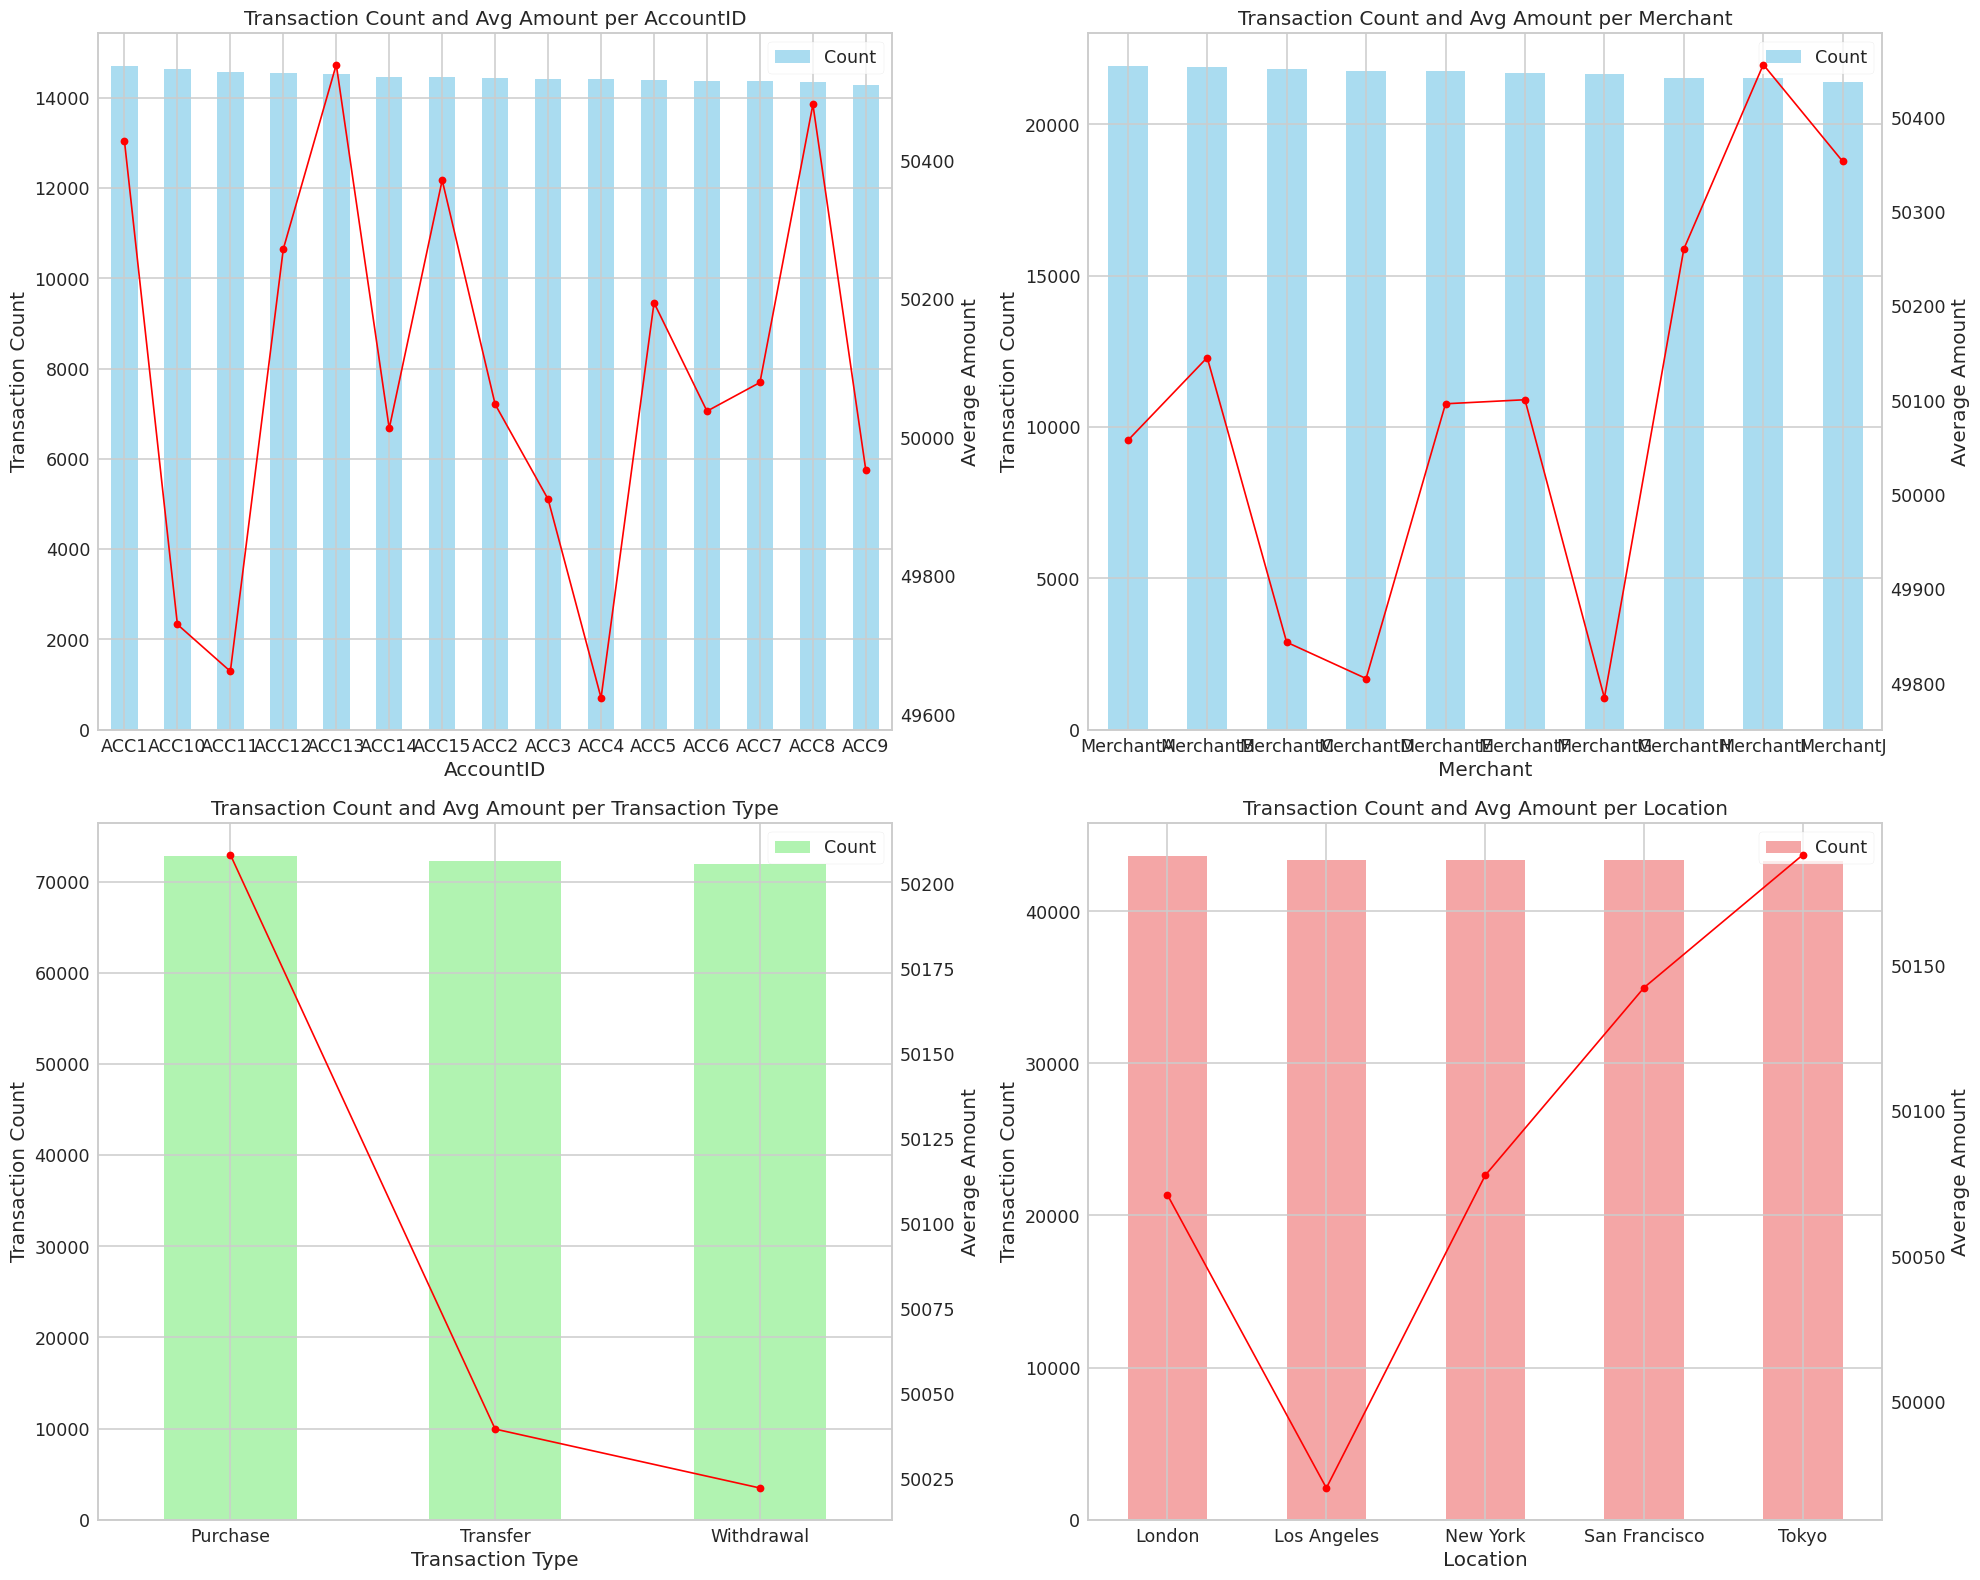

In [18]:
import matplotlib.pyplot as plt

# Set up a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 2: AccountID distribution - Count and Average Amount
AccountID_counts = df['AccountID'].value_counts()
AccountID_avg_amount = df.groupby('AccountID')['Amount'].mean()
AccountID_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue', alpha=0.7, label='Count')
AccountID_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[0, 0], color='red', label='Avg Amount')
axes[0, 0].set_title("Transaction Count and Avg Amount per AccountID")
axes[0, 0].set_xlabel("AccountID")
axes[0, 0].set_ylabel("Transaction Count")
axes[0, 0].right_ax.set_ylabel("Average Amount")
axes[0, 0].legend()

# Plot 2: Merchant distribution - Count and Average Amount
merchant_counts = df['Merchant'].value_counts()
merchant_avg_amount = df.groupby('Merchant')['Amount'].mean()
merchant_counts.plot(kind='bar', ax=axes[0, 1], color='skyblue', alpha=0.7, label='Count')
merchant_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[0, 1], color='red', label='Avg Amount')
axes[0, 1].set_title("Transaction Count and Avg Amount per Merchant")
axes[0, 1].set_xlabel("Merchant")
axes[0, 1].set_ylabel("Transaction Count")
axes[0, 1].right_ax.set_ylabel("Average Amount")
axes[0, 1].legend()

# Plot 3: Transaction Type distribution - Count and Average Amount
type_counts = df['TransactionType'].value_counts()
type_avg_amount = df.groupby('TransactionType')['Amount'].mean()
type_counts.plot(kind='bar', ax=axes[1, 0], color='lightgreen', alpha=0.7, label='Count')
type_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[1, 0], color='red', label='Avg Amount')
axes[1, 0].set_title("Transaction Count and Avg Amount per Transaction Type")
axes[1, 0].set_xlabel("Transaction Type")
axes[1, 0].set_ylabel("Transaction Count")
axes[1, 0].right_ax.set_ylabel("Average Amount")
axes[1, 0].legend()

# Plot 4: Location distribution - Count and Average Amount
location_counts = df['Location'].value_counts()
location_avg_amount = df.groupby('Location')['Amount'].mean()
location_counts.plot(kind='bar', ax=axes[1, 1], color='lightcoral', alpha=0.7, label='Count')
location_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[1, 1], color='red', label='Avg Amount')
axes[1, 1].set_title("Transaction Count and Avg Amount per Location")
axes[1, 1].set_xlabel("Location")
axes[1, 1].set_ylabel("Transaction Count")
axes[1, 1].right_ax.set_ylabel("Average Amount")
axes[1, 1].legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


# Multivariate Anomaly Detection

In this example, we will perform anomaly detection on multiple features of transaction data, such as Amount, TransactionType, and AccountID, using an Isolation Forest model from the pyod library.

The dataset is divided by location because each location may have different spending patterns or transaction amounts. This differentiation allows us to account for location-specific variations in spending behavior, which can affect what is considered "normal" or "anomalous" in each region.

In [19]:
!pip install pyod

In [84]:
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

## Extract Subset Data for Outlier Detection

In [85]:
cols = ['Amount', 'TransactionType', 'Location', 'AccountID']
subset_df = df[cols]
subset_df.head()

,Amount,TransactionType,Location,AccountID
0,95071.92,Purchase,Tokyo,ACC4
1,15607.89,Purchase,London,ACC10
2,65092.34,Withdrawal,London,ACC8
3,87.87,Purchase,London,ACC6
4,716.56,Purchase,Los Angeles,ACC6


In [86]:
# One hot encoding
subset_df = pd.get_dummies(subset_df, columns=['TransactionType', 'AccountID'], drop_first=False)
subset_df.head()

,Amount,Location,TransactionType_Purchase,TransactionType_Transfer,TransactionType_Withdrawal,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,AccountID_ACC13,AccountID_ACC14,AccountID_ACC15,AccountID_ACC2,AccountID_ACC3,AccountID_ACC4,AccountID_ACC5,AccountID_ACC6,AccountID_ACC7,AccountID_ACC8,AccountID_ACC9
0,95071.92,Tokyo,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,15607.89,London,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,65092.34,London,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,87.87,London,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,716.56,Los Angeles,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [87]:
# Columns to scale (Amount, TransactionType, AccountID)
cols_to_scale = ['Amount'] + [col for col in subset_df.columns if col.startswith('TransactionType_') or col.startswith('AccountID_')]
cols_to_scale

['Amount',
 'TransactionType_Purchase',
 'TransactionType_Transfer',
 'TransactionType_Withdrawal',
 'AccountID_ACC1',
 'AccountID_ACC10',
 'AccountID_ACC11',
 'AccountID_ACC12',
 'AccountID_ACC13',
 'AccountID_ACC14',
 'AccountID_ACC15',
 'AccountID_ACC2',
 'AccountID_ACC3',
 'AccountID_ACC4',
 'AccountID_ACC5',
 'AccountID_ACC6',
 'AccountID_ACC7',
 'AccountID_ACC8',
 'AccountID_ACC9']

## Feature Scaling

In [88]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0, 1))
# subset_df[cols] = mms.fit_transform(subset_df)
# subset_df.head()

## Multivariate Anomaly Detection with Isolation Forest

The Isolation Forest (IForest) model is a popular anomaly detection algorithm designed to identify anomalies by isolating data points rather than clustering them. It works by randomly selecting features and values to partition the data and measuring the number of splits required to isolate a data point. Anomalies, which are rare and different from the majority, typically require fewer splits to be isolated than normal points.

### Initialize and Train Model


In [112]:
outliers_per_location = {}

for location in df['Location'].unique():
    # Subset by location
    location_df = subset_df[df['Location'] == location].drop(columns=['Location'])
    location_df[cols_to_scale] = mms.fit_transform(location_df[cols_to_scale])

    rule_based_outliers = pd.Series(0, index=location_df.index)

    account_id_cols = [col for col in location_df.columns if col.startswith('AccountID_')]

    # Layer 1: Rule-Based Detection per AccountID
    for account_id_col in account_id_cols:
        account_df = location_df[location_df[account_id_col] == 1]

        # amount thresholds
        high_threshold = account_df['Amount'].quantile(0.99)
        low_threshold = account_df['Amount'].quantile(0.01)

        # Detect outliers based on amount thresholds for this AccountID
        account_outliers = ((account_df['Amount'] > high_threshold) |
                            (account_df['Amount'] < low_threshold)).astype(int)

        rule_based_outliers.loc[account_df.index] = account_outliers

    # --- Layer 2: Isolation Forest ---
    iforest_model = IsolationForest(contamination=0.01, random_state=42)
    iforest_model.fit(location_df)
    iforest_outliers = (iforest_model.predict(location_df) == -1).astype(int)  # -1 means outlier in IsolationForest

    # --- Layer 3: Ensemble Method (Combine rule-based and Isolation Forest predictions using weighted voting) ---
    ensemble_outliers = (0.4 * rule_based_outliers + 0.6 * iforest_outliers) >= 0.5  # ensemble decision
    location_outliers_df = location_df[ensemble_outliers]
    total_outliers_location = len(location_outliers_df)
    outliers_per_location[location] = total_outliers_location

    location_outliers_df['Location'] = location

    # Save outliers per location
    outlier_var_name = f"outliers_{location}".replace(" ", "_")
    outlier_var_name_model_shape = f"outliers_{location}_model_shape".replace(" ", "_")
    globals()[outlier_var_name] = df.loc[location_outliers_df.index.tolist()][['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']]
    globals()[outlier_var_name_model_shape] = location_outliers_df

    # print(f"Outlier Transactions for {location}:")
    # print(globals()[outlier_var_name])

In [113]:
# # Different weight configurations test (New York)
# configs = [
#     {"rule_weight": 0.4, "iforest_weight": 0.6, "threshold": 0.5},
#     {"rule_weight": 0.6, "iforest_weight": 0.4, "threshold": 0.5},
#     {"rule_weight": 0.5, "iforest_weight": 0.5, "threshold": 0.5},
#     {"rule_weight": 0.4, "iforest_weight": 0.6, "threshold": 0.4},
#     {"rule_weight": 0.5, "iforest_weight": 0.5, "threshold": 0.6},
# ]

# results = []

# for config in configs:
#     ensemble_outliers = (
#         config["rule_weight"] * rule_based_outliers +
#         config["iforest_weight"] * iforest_outliers
#     ) >= config["threshold"]

#     total_outliers = ensemble_outliers.sum()
#     config_result = {
#         "rule_weight": config["rule_weight"],
#         "iforest_weight": config["iforest_weight"],
#         "threshold": config["threshold"],
#         "total_outliers_ny": total_outliers
#     }
#     results.append(config_result)

# pd.DataFrame(results)


## Detected outliers

In [114]:
# outliers total for each location
print("Total Outliers per Location:")
outliers_location_df = pd.DataFrame(list(outliers_per_location.items()), columns=['Location', 'Outlier Count'])
print(outliers_location_df)

Total Outliers per Location:
        Location  Outlier Count
0          Tokyo            416
1         London            433
2    Los Angeles            422
3  San Francisco            437
4       New York            414


In [115]:
outliers_Tokyo.head()

,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
212,TXN707,ACC7,3432.47,MerchantD,Purchase,Tokyo
612,TXN632,ACC7,446.28,MerchantG,Purchase,Tokyo
1274,TXN1639,ACC7,5266.91,MerchantI,Purchase,Tokyo
1526,TXN1975,ACC7,596.41,MerchantH,Purchase,Tokyo
1671,TXN1213,ACC7,88662.68,MerchantD,Purchase,Tokyo


In [116]:
outliers_Los_Angeles.head()

,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
28,TXN1497,ACC7,90683.78,MerchantA,Purchase,Los Angeles
220,TXN588,ACC7,10666.81,MerchantF,Purchase,Los Angeles
712,TXN1438,ACC5,1520.92,MerchantC,Withdrawal,Los Angeles
2876,TXN1244,ACC5,6432.88,MerchantI,Withdrawal,Los Angeles
3746,TXN875,ACC5,6990.93,MerchantI,Withdrawal,Los Angeles


In [117]:
# outliers total
total_outliers_all_locations = sum(outliers_per_location.values())
print(f"\nTotal Outliers across all locations: {total_outliers_all_locations}")


Total Outliers across all locations: 2122


In [118]:
subset_df

,Amount,Location,TransactionType_Purchase,TransactionType_Transfer,TransactionType_Withdrawal,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,AccountID_ACC13,AccountID_ACC14,AccountID_ACC15,AccountID_ACC2,AccountID_ACC3,AccountID_ACC4,AccountID_ACC5,AccountID_ACC6,AccountID_ACC7,AccountID_ACC8,AccountID_ACC9
0,95071.92,Tokyo,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,15607.89,London,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,65092.34,London,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,87.87,London,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,716.56,Los Angeles,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216955,62536.88,San Francisco,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
216956,68629.69,London,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
216957,8203.57,London,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
216958,77800.36,New York,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [119]:
# Menggabungkan semua indeks dari DataFrame outlier
outlier_indices = (
    outliers_Tokyo_model_shape.index
    .union(outliers_London_model_shape.index)
    .union(outliers_New_York_model_shape.index)
    .union(outliers_San_Francisco_model_shape.index)
    .union(outliers_Los_Angeles_model_shape.index)
)

# Memfilter DataFrame df untuk hanya menampilkan baris yang bukan outlier
non_outliers_df = subset_df[~subset_df.index.isin(outlier_indices)]

# Menampilkan hasil
non_outliers_df

,Amount,Location,TransactionType_Purchase,TransactionType_Transfer,TransactionType_Withdrawal,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,AccountID_ACC13,AccountID_ACC14,AccountID_ACC15,AccountID_ACC2,AccountID_ACC3,AccountID_ACC4,AccountID_ACC5,AccountID_ACC6,AccountID_ACC7,AccountID_ACC8,AccountID_ACC9
0,95071.92,Tokyo,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,15607.89,London,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,65092.34,London,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,87.87,London,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,716.56,Los Angeles,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216955,62536.88,San Francisco,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
216956,68629.69,London,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
216957,8203.57,London,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
216958,77800.36,New York,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [120]:
non_outliers_df.iloc[28]

,30
Amount,22218.56
Location,London
TransactionType_Purchase,False
TransactionType_Transfer,False
TransactionType_Withdrawal,True
AccountID_ACC1,False
AccountID_ACC10,False
AccountID_ACC11,False
AccountID_ACC12,False
AccountID_ACC13,False


## Get Specific location

In [33]:
subset_df

,Amount,Location,TransactionType_Purchase,TransactionType_Transfer,TransactionType_Withdrawal,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,AccountID_ACC13,AccountID_ACC14,AccountID_ACC15,AccountID_ACC2,AccountID_ACC3,AccountID_ACC4,AccountID_ACC5,AccountID_ACC6,AccountID_ACC7,AccountID_ACC8,AccountID_ACC9
0,95071.92,Tokyo,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,15607.89,London,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,65092.34,London,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,87.87,London,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,716.56,Los Angeles,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216955,62536.88,San Francisco,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
216956,68629.69,London,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
216957,8203.57,London,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
216958,77800.36,New York,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [ ]:
def df_by_location_transaction(location):
    # Tentukan lokasi yang ingin Anda analisis
    target_location = location  # Misalnya "Tokyo" atau lokasi lain

    # Buat subset data untuk lokasi yang ditentukan
    location_df = subset_df[df['Location'] == target_location].drop(columns=['Location'])  # Drop kolom Location

    # Skala kolom yang diperlukan
    location_df[cols_to_scale] = mms.fit_transform(location_df[cols_to_scale])

    # Inisialisasi model IForest dan fit pada data lokasi tertentu
    iforest_model = IForest(contamination=0.01, random_state=42)
    iforest_model.fit(location_df)

    # Prediksi outlier
    outlier_predictions = iforest_model.predict(location_df)

    # Simpan hasil outlier dalam DataFrame baru
    location_outliers_df = location_df.copy(deep=True)
    location_outliers_df['Outlier'] = outlier_predictions
    location_outliers_df = location_outliers_df[location_outliers_df['Outlier'] == 1]  # Hanya outlier

    # Hitung jumlah total outlier di lokasi ini
    total_outliers_location = len(location_outliers_df)
    outliers_per_location = {target_location: total_outliers_location}

    # Tambahkan kolom 'Location' kembali untuk identifikasi
    location_outliers_df['Location'] = target_location

    # Ambil data asli dari `df` berdasarkan indeks outlier yang terdeteksi
    outliers_data = df.loc[location_outliers_df.index.tolist()][['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']]

    # Ambil data non-outlier dengan mengecualikan transaksi yang ada di outliers_data dari subset_df
    non_outliers_data = df.loc[~df.index.isin(location_outliers_df.index)][['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']]
    non_outliers_data = non_outliers_data[non_outliers_data['Location'] == target_location]

    # Print hasil
    print(f"Outlier Transactions for {target_location}:")
    print(outliers_data)
    print(f"Total outliers detected for {target_location}: {total_outliers_location}")

    print(f"Non-outlier Transactions for {target_location}:")
    print(non_outliers_data)

    return outliers_data, non_outliers_data


In [ ]:
# Example usage
anomaly_df, non_anomaly_df = df_by_location_transaction('Tokyo')

Outlier Transactions for Tokyo:
       TransactionID AccountID    Amount   Merchant TransactionType Location
212           TXN707      ACC7   3432.47  MerchantD        Purchase    Tokyo
612           TXN632      ACC7    446.28  MerchantG        Purchase    Tokyo
1274         TXN1639      ACC7   5266.91  MerchantI        Purchase    Tokyo
1526         TXN1975      ACC7    596.41  MerchantH        Purchase    Tokyo
1671         TXN1213      ACC7  88662.68  MerchantD        Purchase    Tokyo
...              ...       ...       ...        ...             ...      ...
214212        TXN254      ACC7   7833.44  MerchantA        Purchase    Tokyo
214799        TXN386     ACC12  99233.87  MerchantA        Purchase    Tokyo
214816       TXN1210      ACC7  90407.19  MerchantJ        Purchase    Tokyo
215968        TXN477      ACC5  98689.12  MerchantC      Withdrawal    Tokyo
216249        TXN808      ACC2   4063.50  MerchantC      Withdrawal    Tokyo

[416 rows x 6 columns]
Total outliers detec

# Generative AI (OpenAI API)

In [ ]:
!pip install openai

In [ ]:
!openai migrate

Error: Failed to download Grit CLI from https://github.com/getgrit/gritql/releases/latest/download/marzano-x86_64-unknown-linux-gnu.tar.gz


In [ ]:
# Fetching API

from openai import OpenAI
import openai
from google.colab import userdata
import time

openai.api_key = userdata.get('OpenAI')

In [ ]:
def generate_explanation(transaction_data, non_anomaly_df, user_input):

    non_anomaly_avg_amount = non_anomaly_df[
      (non_anomaly_df['Merchant'] == transaction_data['Merchant']) &
      (non_anomaly_df['AccountID'] == transaction_data['AccountID']) &
      (non_anomaly_df['TransactionType'] == transaction_data['TransactionType'])
    ]['Amount'].mean()

    non_anomaly_avg_amount = non_anomaly_avg_amount if not pd.isna(non_anomaly_avg_amount) else 0

    base_prompt = (
      "Explain why the transaction with ID " + str(transaction_data['TransactionID']) +
      " is considered an anomaly. Include comparisons of the amount (" + str(transaction_data['Amount']) +
      ") to the average transaction (" + str(non_anomaly_avg_amount) +
      ") for similar accounts, locations, and types. Note any unusual factors like sudden location changes, high amounts, "
      "or atypical merchant types, and provide insights into why this transaction may need further review."
    )


    if user_input != "":
        base_prompt += f" User asked: '{user_input}'"

    client = openai.OpenAI(api_key=openai.api_key)

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an AI assistant that explains transaction anomalies."},
            {"role": "user", "content": base_prompt}
        ],
        temperature=0.7,
        max_tokens=150,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    explanation = response.choices[0].message['content'].strip()
    return explanation


In [ ]:
def select_transactionID(anomaly_df, TransactionID):
    temp = anomaly_df[anomaly_df['TransactionID'] == TransactionID].iloc[0]

    if temp.empty:
        return None

    transaction_data = {
        "TransactionID": temp['TransactionID'],
        "AccountID": temp['AccountID'],
        "Amount": temp['Amount'],
        "Merchant": temp['Merchant'],
        "TransactionType": temp['TransactionType'],
        "Location": temp['Location']
    }

    return transaction_data


In [ ]:
transaction_data = select_transactionID(anomaly_df, "TXN1639")

generate_explanation(transaction_data, non_anomaly_df, "")

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

# Generative AI(Gemini AI)

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import google.generativeai as genai
from google.colab import userdata

genai.configure(api_key=userdata.get('GeminiAI'))

In [ ]:
gemini = genai.GenerativeModel("gemini-1.5-flash")

In [ ]:
def gemini_explanation(transaction_data, non_anomaly_df, user_input):

    non_anomaly_avg_amount = non_anomaly_df[
      (non_anomaly_df['Merchant'] == transaction_data['Merchant']) &
      (non_anomaly_df['AccountID'] == transaction_data['AccountID']) &
      (non_anomaly_df['TransactionType'] == transaction_data['TransactionType'])
    ]['Amount'].mean()

    non_anomaly_avg_amount = non_anomaly_avg_amount if not pd.isna(non_anomaly_avg_amount) else 0

    base_prompt = (
      "Explain why the transaction with ID " + str(transaction_data['TransactionID']) +
      " is considered an anomaly. Include comparisons of the amount (" + str(transaction_data['Amount']) +
      ") to the average transaction (" + str(non_anomaly_avg_amount) +
      ") for similar accounts " + str(transaction_data['AccountID']) +
      ", locations " + str(transaction_data['Location']) +
      ", and types " + str(transaction_data['TransactionType']) + "."

      "Where, this transaction is one of the several financial tansaction records on ERP Website System, that we dealing for some" + str(transaction_data['Merchant']) +
      ". This Anomaly found by our model to detect anomly transaction and now i want you make explanation for giving more reasonable why this transaction is anomaly"
    )

    print(base_prompt)

    if user_input != "":
        base_prompt += f" User asked: '{user_input}'"

    response = gemini.generate_content(base_prompt)

    file_name = f"response_{transaction_data['TransactionID']}.txt"
    with open(file_name, "w") as file:
      file.write(response.text)

    # Output hasil text
    print(response.text)
    # return response.text

In [ ]:
gemini_explanation(transaction_data, non_anomaly_df, "")

Explain why the transaction with ID TXN1639 is considered an anomaly. Include comparisons of the amount (5266.91) to the average transaction (46611.19882352942) for similar accounts ACC7, locations Tokyo, and types Purchase.Where, this transaction is one of the several financial tansaction records on ERP Website System, that we dealing for someMerchantI. This Anomaly found by our model to detect anomly transaction and now i want you make explanation for giving more reasonable why this transaction is anomaly
##  Why Transaction TXN1639 is an Anomaly

Transaction TXN1639, with an amount of 5266.91, is considered an anomaly based on its significant deviation from the average transaction amount for similar transactions. 

Here's a breakdown:

* **Transaction Amount:** 5266.91
* **Average Transaction Amount (Similar Transactions):** 46611.19882352942

**The discrepancy:** The average transaction amount for similar transactions (those from account ACC7, in Tokyo, and of type Purchase) is alm